In [1]:
import pandas as pd

import sys
# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data
from src.utils import plot_metrics_grid
from src.utils import load_baseline_rec_result
from src.metrics import evaluate_recommender_system

In [2]:

import numpy as np
from scipy.sparse import csr_matrix, find
import warnings

# Convert RuntimeWarning to an error
warnings.filterwarnings("error", category=RuntimeWarning)

def funk_svd_sparse(R, num_factors=10, alpha=0.01, beta=0.01, num_iterations=100, epsilon = 0.001):
    """
    Perform Funk SVD on the given sparse user-item matrix R.

    Parameters:
    - R (csr_matrix): Sparse user-item matrix.
    - num_factors (int): Number of latent factors.
    - alpha (float): Learning rate.
    - beta (float): Regularization parameter.
    - num_iterations (int): Number of iterations for SGD.
    - epsilon (float): Minimal change in rmse to keep training.

    Returns:
    - U (ndarray): User-factor matrix.
    - V (ndarray): Item-factor matrix.
    """
    num_users, num_items = R.shape
    U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
    V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

    training_process = []

    for iteration in range(num_iterations):
        # Get the non-zero indices (observed ratings)
        rows, cols, values = find(R)

        for i, j, r in zip(rows, cols, values):
            prediction = np.dot(U[i, :], V[j, :])
            error = r - prediction

            # Update user and item latent feature matrices
            U[i, :] += alpha * (error * V[j, :] - beta * U[i, :])
            V[j, :] += alpha * (error * U[i, :] - beta * V[j, :])

        rmse = np.sqrt(np.mean([(r - np.dot(U[i, :], V[j, :]))**2 for i, j, r in zip(rows, cols, values)]))
        training_process.append((iteration, rmse))
        print(f"Iteration: {iteration+1}, RMSE: {rmse}")
        if len(training_process) >= 2  and rmse + epsilon >= training_process[-2][1]:
            print("Early stopping!")
            break

    return U, V, training_process

In [3]:
users,ratings,movies = load_data('../../data/ml-1m')

In [4]:
ratings = ratings.sort_values(by='timestamp',ascending=True)
train_ratings, test_ratings = ratings.iloc[:int(len(ratings)*0.8)],ratings.iloc[int(len(ratings)*0.8):]


In [5]:
user_item_matrix_train = train_ratings.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix_train.fillna(0,inplace=True)
user_item_matrix_train.shape

(5400, 3662)

In [6]:
def predict_ratings(U, V):
    """
    Predict ratings for all user-item pairs.

    Parameters:
    - U (ndarray): User latent feature matrix.
    - V (ndarray): Item latent feature matrix.

    Returns:
    - predicted_ratings (ndarray): Matrix of predicted ratings.
    """
    return np.dot(U, V.T)

def generate_recommendations(U, V, train_ratings, k=5):
    """
    Generate top-k recommendations for each user, excluding movies seen in training.

    Parameters:
    - U (ndarray): User latent feature matrix.
    - V (ndarray): Item latent feature matrix.
    - train_ratings (DataFrame): Training ratings DataFrame with columns ['user_id', 'movie_id', 'rating'].
    - k (int): Number of recommendations to generate for each user.

    Returns:
    - recommendations (dict): Dictionary of recommendations where keys are user IDs and values are lists of recommended movie IDs.
    """
    # Predict ratings
    predicted_ratings = predict_ratings(U, V)
    
    # Create a DataFrame from the predicted ratings
    user_index = {user: idx for idx, user in enumerate(train_ratings['user_id'].unique())}
    item_index = {item: idx for idx, item in enumerate(train_ratings['movie_id'].unique())}
    user_ids = train_ratings['user_id'].unique()
    movie_ids = train_ratings['movie_id'].unique()
    predicted_df = pd.DataFrame(predicted_ratings, index=user_ids, columns=movie_ids)
    
    # Exclude movies seen in training
    train_user_item = train_ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    for user in train_user_item.index:
        seen_movies = train_user_item.loc[user][train_user_item.loc[user] > 0].index
        predicted_df.loc[user, seen_movies] = -np.inf
    
    # Generate top-k recommendations
    recommendations = {}
    for user in user_ids:
        recommended_items = predicted_df.loc[user].nlargest(k).index.tolist()
        recommendations[user] = recommended_items
    
    return recommendations

## Perform grid-search

In [7]:
import random

factor_values = [5,10,15,20,25,30]
alpha_values = [0.005,0.01,0.02]
num_iteration_values = [10,15,20,25,30,40]
beta_values = alpha_values.copy()
num_samples = 10
random_samples = [
    (random.choice(factor_values), random.choice(num_iteration_values), random.choice(beta_values), random.choice(alpha_values))
    for _ in range(num_samples)
]
results = []
for factor, iterations, beta_value, alpha_value in random_samples:
    print(factor, alpha_value, beta_value, iterations)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)
            U, V, training_process = funk_svd_sparse(user_item_matrix_train, num_factors=factor, alpha=alpha_value, beta=beta_value, num_iterations=iterations, epsilon=0.001)
            recommendations = generate_recommendations(U, V, train_ratings, k=25)
            results.append({(factor, iterations, beta_value, alpha_value): recommendations})
    except RuntimeWarning as warn:
        print(f"{warn} Stopping execution")

30 0.01 0.005 40
Iteration: 1, RMSE: 3.422069512446492
Iteration: 2, RMSE: 1.4599881943975386
Iteration: 3, RMSE: 1.1629150354922964
overflow encountered in multiply Stopping execution
20 0.005 0.01 15
Iteration: 1, RMSE: 2.4255589748758477
Iteration: 2, RMSE: 1.185293566167079
Iteration: 3, RMSE: 1.0054361636779994
Iteration: 4, RMSE: 0.9593927643641289
Iteration: 5, RMSE: 0.9342947050831621
Iteration: 6, RMSE: 0.9160908064324442
Iteration: 7, RMSE: 0.9006741748934626
Iteration: 8, RMSE: 0.8871562027297829
Iteration: 9, RMSE: 0.8751804286912936
Iteration: 10, RMSE: 0.8643514823846293
Iteration: 11, RMSE: 0.8543192983039091
Iteration: 12, RMSE: 0.844837654793918
Iteration: 13, RMSE: 0.8357686969650384
Iteration: 14, RMSE: 0.8270661017217581
Iteration: 15, RMSE: 0.8187430679900776
20 0.005 0.005 10
Iteration: 1, RMSE: 2.3796708160289324
Iteration: 2, RMSE: 1.1051425164964157
Iteration: 3, RMSE: 0.9813645560637676
Iteration: 4, RMSE: 0.9497235103933689
Iteration: 5, RMSE: 0.9318353907591

In [13]:
metrics = {}
total_movies = len(ratings['movie_id'].unique())
k_values = [25, 20, 15, 10, 5]

for res in results:
    for k_tuple in res:
        recommendation_ = res[k_tuple]
        metrics[k_tuple] = {}
        for k in k_values:
            cropped_recommendation = {user: films[:k] for user, films in recommendation_.items()}
            metrics[k_tuple][k] = evaluate_recommender_system(cropped_recommendation, test_ratings, total_movies, k)

In [22]:
import json
metrics_with_str_keys = {str(k): v for k, v in metrics.items()}

json.dump(metrics_with_str_keys, open("../../artifacts/funk_svd_metrics.json", "w"))

In [17]:
metrics_names = ['Precision@K', 'Recall@K', 'NDCG@K', 'MAP@K', 'MRR', 'Hit Rate@K', 'Coverage@K']

In [23]:
baseline_res = load_baseline_rec_result()

In [24]:
all_metrics = baseline_res | metrics

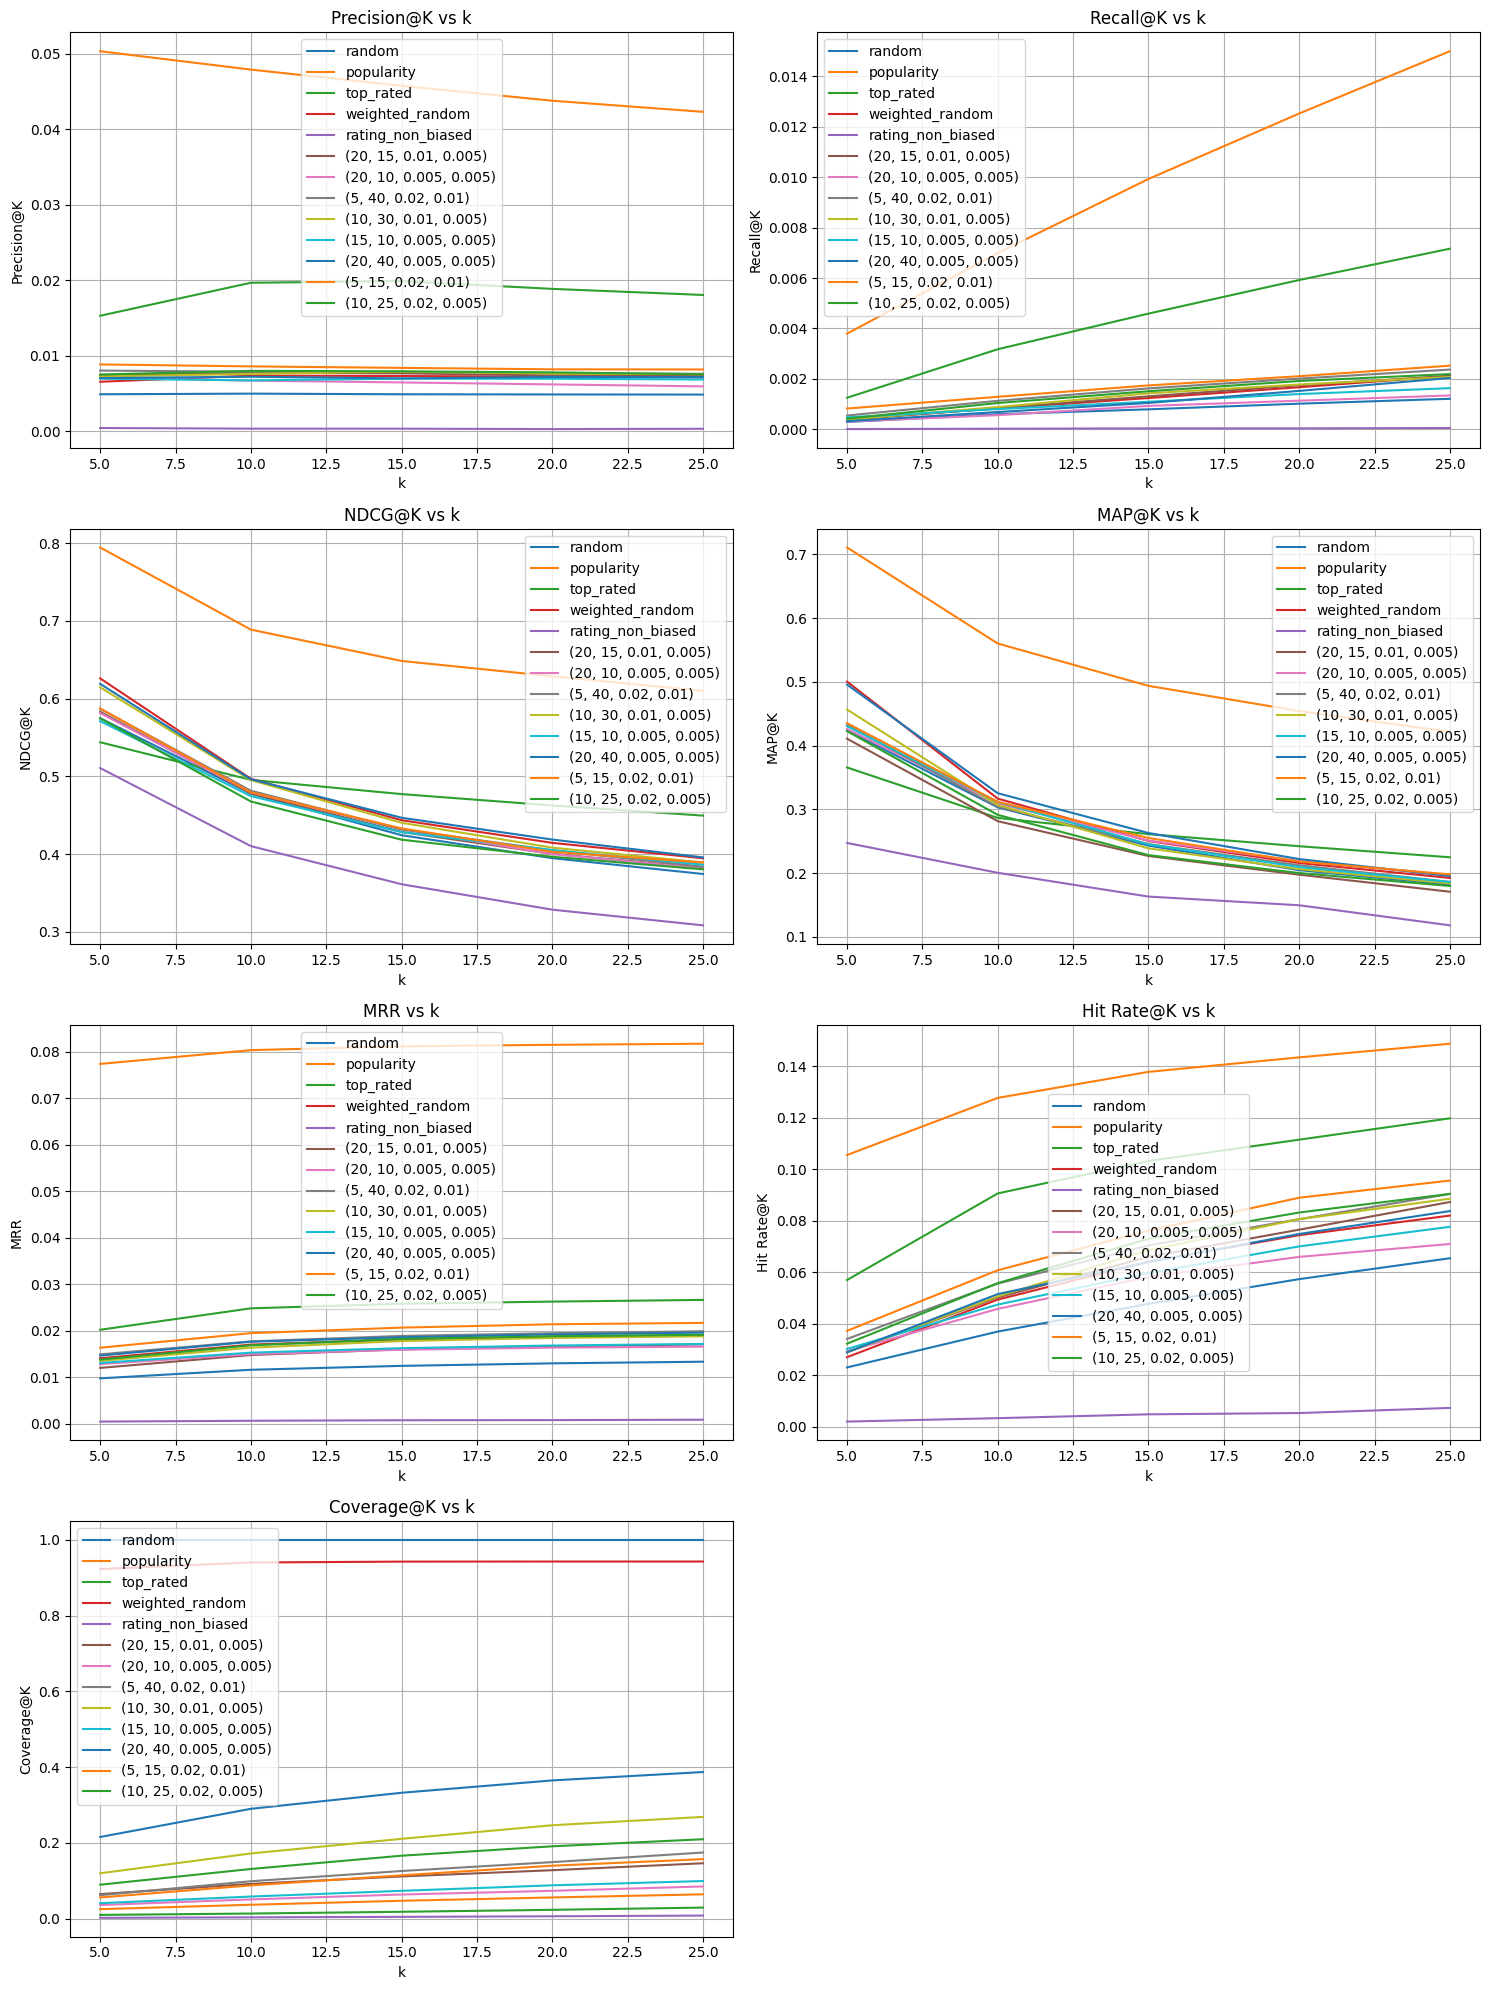

In [25]:
plot_metrics_grid(all_metrics, metrics_names)

Comparing metrics with baseline recommender based on popularity, we can see that funksvd performs worse than popularity-recommeder.

For instance, precision@k is approx 0.05 with baseline and here we don't even have 0.01. 
NDCG@k varies from 0.6 to approx 0.8 for baseline and here it varies from 0.4 to 0.6 (depending on k).

Therefore we can tell that funksvd in this implementation did not outperform baseline recommeder and actually performed significantly worse.